## Prognozowanie tygodniowej sprzedaży na rok do przodu.

### Metryka sukcesu


Metryką sukcesu w tym zadaniu będzie: `MAE` 


## ✔️ Wczytujemy biblioteki

In [1]:
# Podstawowe biblioteki
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Przygotowanie danych
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder

# Modele
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# Poprawa Modelu 
from sklearn.metrics import mean_absolute_error,mean_squared_error 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Wizualizacja
import seaborn as sns
import scikitplot as skplt
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sns.color_palette()
import matplotlib.ticker as mtick
from IPython.display import display
pd.options.display.max_columns = None
from pandas.plotting import scatter_matrix

# Utilities
import os
import re
import sys
import string
import time
from datetime import datetime
from time import time
from scipy.stats import pointbiserialr
from tqdm import tqdm
import eli5
from eli5.sklearn import PermutationImportance
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval

## ✔️ Wczytujemy dane

In [2]:
df_sales_train = pd.read_hdf("../input/sales_train.h5")
df_sales_test = pd.read_hdf("../input/sales_test.h5")
df_sales_train.sample(5)

,id,weekly_sales,store,dept,date,is_holiday
248029,248029,3061.379883,39,6,19/08/2011,False
199832,199832,32100.279297,10,1,24/09/2010,False
175383,175383,3021.350098,17,93,30/04/2010,False
366157,366157,3705.600098,18,44,29/04/2011,False
169070,169070,2500.139893,24,71,07/01/2011,False


In [3]:
df_stores_data = pd.read_csv('../input/stores_data.csv')
df_stores_data.rename({'Store': 'store'}, axis=1, inplace=True)
df_stores_data.sample(5)

,store,Type,Size
9,10,B,126512
38,39,A,184109
32,33,A,39690
42,43,C,41062
44,45,B,118221


## Sales

Historyczne dane sprzedaży. W tej zakładce znajdziesz następujące pola:

- `store` - numer sklepu (sklep zawiera jeden lub więcej oddziałów)
- `dept` - numer oddziału
- `date` - tydzień (dane są zebrane w tygodniowe grupy)
- `weekly_sales` -  sprzedaż dla danego działu w danym sklepie
- `is_holiday` - czy tydzień jest specjalnym tygodniem (świątecznym)



## 🕵️‍♀️ Sprawdzamy dane

In [4]:
print(df_sales_train.shape, df_sales_test.shape)
df_sales_train.info()

(285089, 6) (136481, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 285089 entries, 1 to 421567
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            285089 non-null  int32  
 1   weekly_sales  285089 non-null  float32
 2   store         285089 non-null  int8   
 3   dept          285089 non-null  int8   
 4   date          285089 non-null  object 
 5   is_holiday    285089 non-null  bool   
dtypes: bool(1), float32(1), int32(1), int8(2), object(1)
memory usage: 7.3+ MB


## 💡 Pierwsze wnioski
- mamy 285 089 wiersze w zbiorze treningowym oraz 136 481 wiersze w zbiorze testowym
- mamy 6 kolumn, z czego jedna to nasza odpowiedź (czyli kolumna `weekly_sales`)
- pomijając 2 kolumny (`id` oraz `weekly_sales`), możemy wstępnie stwierdzić, że mamy 4 cechy i są one numeryczne (`float` lub `int` oraz jedna data)
- nie mamy braków w danych (czyli już ktoś za nas na tym popracował). 

## Merging Data

In [5]:
def merging(df1,df2,on1):
    df_final = df1.merge(df2, how = 'left', on = on1)
    return df_final

In [6]:
df_merged_train = merging(df_sales_train,df_stores_data, on1 = ['store'])
df_merged_test = merging(df_sales_test,df_stores_data, on1 = ['store'])

In [7]:
df_merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285089 entries, 0 to 285088
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            285089 non-null  int32  
 1   weekly_sales  285089 non-null  float32
 2   store         285089 non-null  int8   
 3   dept          285089 non-null  int8   
 4   date          285089 non-null  object 
 5   is_holiday    285089 non-null  bool   
 6   Type          285089 non-null  object 
 7   Size          285089 non-null  int64  
dtypes: bool(1), float32(1), int32(1), int64(1), int8(2), object(2)
memory usage: 11.7+ MB


In [8]:
def date_features(df):
    df['date'] = pd.to_datetime(df['date'],dayfirst = True)
    #df['date'] = pd.to_datetime(df['date'])
    
    df["year"] =  df["date"].dt.year
    df["month"] =  df["date"].dt.month
    df["day"] =  df["date"].dt.day
    df["hour"] =  df["date"].dt.hour
    df["week"] =  df["date"].dt.week
    df["weekofyear"] =  df["date"].dt.weekofyear
    df["dayofweek"] =  df["date"].dt.dayofweek
    df["weekday"] =  df["date"].dt.weekday
    df["dayofyear"] =  df["date"].dt.dayofyear
    df["quarter"] =  df["date"].dt.quarter
    df["is_month_start"] =  df["date"].dt.is_month_start
    df["is_month_end"] =  df["date"].dt.is_month_end
    df["is_quarter_start"] =  df["date"].dt.is_quarter_start
    df["is_quarter_end"] =  df["date"].dt.is_quarter_end
    df["is_year_start"] =  df["date"].dt.is_year_start
    df["is_year_end"] =  df["date"].dt.is_year_end
    df["is_leap_year"] =  df["date"].dt.is_leap_year
    df["daysinmonth"] =  df["date"].dt.daysinmonth

    return df

In [9]:
df_merged_train_date_transformed = date_features(df_merged_train)
df_merged_test_date_transformed = date_features(df_merged_test)

In [11]:
df_merged_train_date_transformed.sample()

,id,weekly_sales,store,dept,date,is_holiday,Type,Size,year,month,day,hour,week,weekofyear,dayofweek,weekday,dayofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year,daysinmonth
77830,115139,62177.550781,23,72,2011-01-14,False,B,114533,2011,1,14,0,2,2,4,4,14,1,False,False,False,False,False,False,False,31


## ✔️ EDA, Preprocessing & Cleaning

<AxesSubplot:>

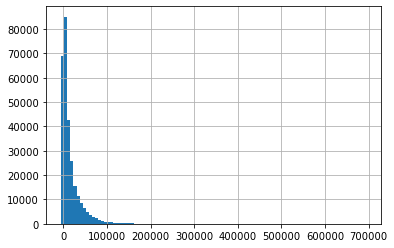

In [12]:
df_merged_train_date_transformed['weekly_sales'].hist(bins = 100)

In [13]:
df_merged_train_anomalies_removed = df_merged_train_date_transformed[
                                    #(df_merged_train_date_transformed['weekly_sales']<200000) & 
                                    (df_merged_train_date_transformed['weekly_sales']>0)]

Zadanie, które mamy to jest regresja. Widać, że rozkład ma tak zwany długi ogon. Są rzadkie przypadki, kiedy sprzedaż, była znacząco większa niż dla większości przypadków.

<AxesSubplot:>

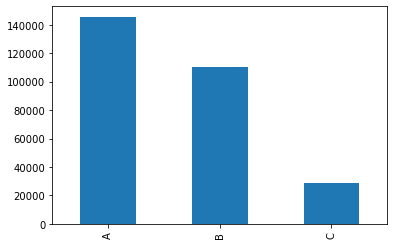

In [14]:
df_merged_train_anomalies_removed['Type'].value_counts().plot(kind = 'bar')

<AxesSubplot:xlabel='Type', ylabel='weekly_sales'>

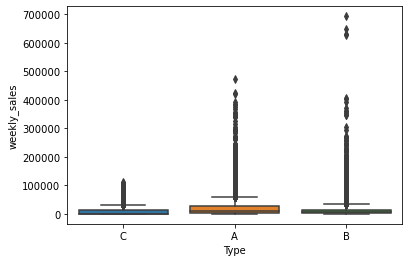

In [15]:
sns.boxplot(x='Type', y='weekly_sales', data=df_merged_train_anomalies_removed)

<AxesSubplot:xlabel='is_holiday', ylabel='weekly_sales'>

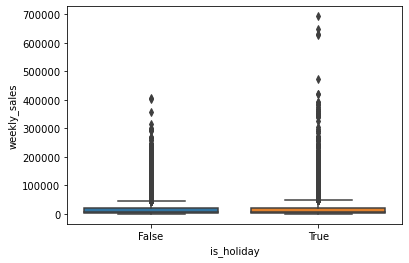

In [16]:
sns.boxplot(x='is_holiday', y='weekly_sales', data=df_merged_train_anomalies_removed)

In [17]:
df_merged_train_anomalies_removed['is_holiday'] = df_merged_train_anomalies_removed['is_holiday'].apply(lambda x: int(x))
df_merged_test_date_transformed['is_holiday'] = df_merged_test_date_transformed['is_holiday'].apply(lambda x: int(x))

<ipython-input-17-5c09d9a2349d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_train_anomalies_removed['is_holiday'] = df_merged_train_anomalies_removed['is_holiday'].apply(lambda x: int(x))


<AxesSubplot:xlabel='month', ylabel='weekly_sales'>

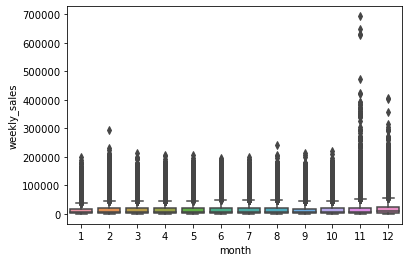

In [18]:
sns.boxplot(x='month', y='weekly_sales', data=df_merged_train_anomalies_removed)

<AxesSubplot:xlabel='week', ylabel='weekly_sales'>

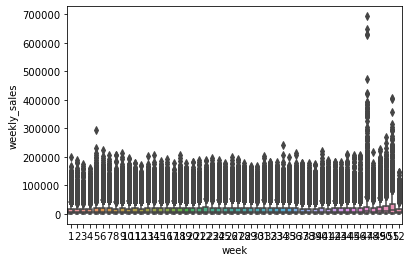

In [19]:
sns.boxplot(x='week', y='weekly_sales', data=df_merged_train_anomalies_removed)

<AxesSubplot:xlabel='quarter', ylabel='weekly_sales'>

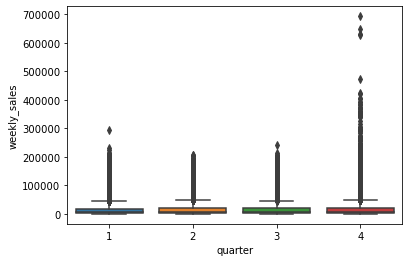

In [20]:
sns.boxplot(x='quarter', y='weekly_sales', data=df_merged_train_anomalies_removed)

<AxesSubplot:>

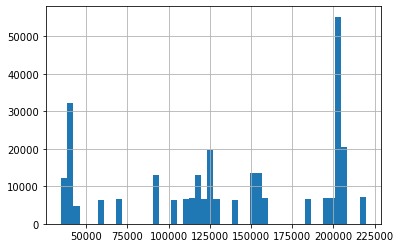

In [21]:
df_merged_train_anomalies_removed['Size'].hist(bins = 50)

<AxesSubplot:xlabel='Size', ylabel='weekly_sales'>

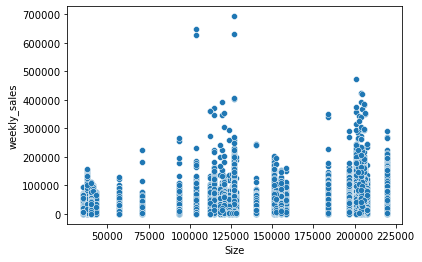

In [22]:
sns.scatterplot(x = 'Size', y = 'weekly_sales',data = df_merged_train_anomalies_removed)

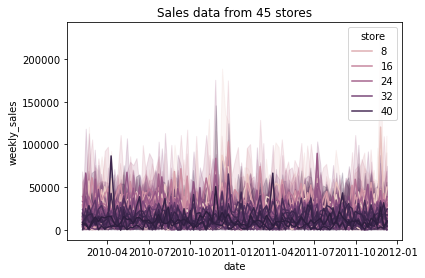

In [23]:
plt.title("Sales data from 45 stores")
sns.lineplot(x='date', y='weekly_sales', hue='store', data=df_merged_train_anomalies_removed.sample(frac=0.1,random_state = 0));

<AxesSubplot:>

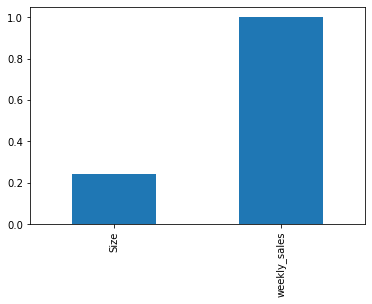

In [24]:
df_merged_train_anomalies_removed[['Size','weekly_sales']].corr()['weekly_sales'].sort_values().plot(kind = 'bar')

In [25]:
df_train = df_merged_train_anomalies_removed.copy()
df_test = df_merged_test_date_transformed.copy()

<AxesSubplot:>

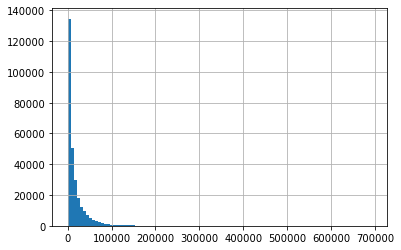

In [26]:
df_train['weekly_sales'].hist(bins = 100)

In [27]:
df_train['weekly_sales'] = df_train['weekly_sales'].map(lambda x: np.log(x))

<AxesSubplot:>

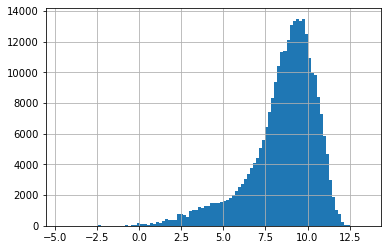

In [28]:
df_train['weekly_sales'].hist(bins = 100)

In [29]:
def type_cat(x):
    if x == 'A':
        return 1
    elif x == 'B':
        return 2
    return 3

def feature_engineering(df):
    
    # Zmiana kolumny Type na numeryczne
    df['type_cat'] = df['Type'].map(type_cat)
    
    #liczba oddzialow dla sklepu
    temp_sum_dept = df_train.groupby('store')['dept'].nunique()
    df['sum_dept'] = df['store'].apply(lambda x: temp_sum_dept[x])
    
    #identyfikator dla kombinacji sklep-oddzial
    df['id-store-dept'] = df[['store','dept']].apply(lambda x: x['store']*1000 + x['dept'], axis=1)
    
    #przypisanie sredniej ceny z przeszlosci (analogiczny okres roku poprzedniego, sprzedaz zlogarytmowana)
    df["year_minus_1"] = df["year"] - 1
    
    df_sales_group = df_train.groupby(["id-store-dept", "year", "week"]).agg("mean")[ ["weekly_sales"] ].reset_index()
    df_sales_group = df_sales_group.rename(columns={'year': 'year_minus_1',
                                                   'weekly_sales': 'PY_week_log_sales'})
    
    df = pd.merge(df, df_sales_group, on = ['id-store-dept', 'year_minus_1', 'week'], how = 'left')
    
    df_sales_group_2 = df_train.groupby(["id-store-dept", "year", "month"]).agg("mean")[ ["weekly_sales"] ].reset_index()
    df_sales_group_2 = df_sales_group_2.rename(columns={'year': 'year_minus_1',
                                                   'weekly_sales': 'PY_month_log_sales'})

    df = pd.merge(df, df_sales_group_2, on = ['id-store-dept', 'year_minus_1', 'month'], how = 'left')
    
    
    #przypisanie podst. charakterystyk dot. sklepu (starter 4) (sprzedaz zlogarytmowana)
    df_store_stats = df_train.groupby(["store"]).agg(["mean", "std", "median", "size"])["weekly_sales"].reset_index()
    df_store_stats.rename(columns= { 
                                'mean': 'store_mean', 
                                'std': 'store_std', 
                                'median': 'store_median', 
                                'size': 'store_size'},
                      inplace = True
                     )
    
    df_store_stats_dept = df_train.groupby(['store','dept']).agg(["mean", "std", "median", "size"])["weekly_sales"].reset_index()
    df_store_stats_dept.rename(columns= { 
                                'mean': 'dept_mean', 
                                'std': 'dept_std', 
                                'median': 'dept_median', 
                                'size': 'dept_size'},
                      inplace = True
                     )
    
    df = pd.merge(df, df_store_stats, on = ['store'], how = 'left')
    df = pd.merge(df, df_store_stats_dept, on = ['store', 'dept'], how = 'left')
    
    #braki danych
    #df.fillna(0, inplace = True)
#     df.drop(['id-store-dept'],axis = 1, inplace = True
#            )              
    return df

In [30]:
df_train_feature_engineering = feature_engineering(df_train)
df_test_feature_engineering = feature_engineering(df_test)

In [32]:
df_train_feature_engineering.shape, df_test_feature_engineering.shape

((284201, 40), (136481, 39))

In [33]:
df_train_final = df_train_feature_engineering.drop(['id','date','year_minus_1','id-store-dept','Type'],axis = 1)
df_test_final = df_test_feature_engineering.drop(['id','date','year_minus_1','id-store-dept','Type'],axis = 1)

## Modelowanie

In [41]:
X = df_train_final.drop(['weekly_sales'],axis = 1)
y = df_train_final['weekly_sales']

In [46]:
feats = [col for col in df_train_final.columns if col != 'weekly_sales']
feats

['store',
 'dept',
 'is_holiday',
 'Size',
 'year',
 'month',
 'day',
 'hour',
 'week',
 'weekofyear',
 'dayofweek',
 'weekday',
 'dayofyear',
 'quarter',
 'is_month_start',
 'is_month_end',
 'is_quarter_start',
 'is_quarter_end',
 'is_year_start',
 'is_year_end',
 'is_leap_year',
 'daysinmonth',
 'type_cat',
 'sum_dept',
 'PY_week_log_sales',
 'PY_month_log_sales',
 'store_mean',
 'store_std',
 'store_median',
 'store_size',
 'dept_mean',
 'dept_std',
 'dept_median',
 'dept_size']

In [43]:
scores = []
names = []
models = []

tscv = TimeSeriesSplit(n_splits=2)

#models.append(('Linear Regression', LinearRegression()))
#models.append(('Decision Tree', DecisionTreeRegressor(random_state = 0)))
#models.append(('Random Forest', RandomForestRegressor(random_state=0)))
models.append(('CatBoost', CatBoostRegressor(verbose= False)))
models.append(('XGBoost', XGBRegressor(verbosity = 0)))
#models.append(('Random Forest', RandomForestRegressor(random_state=0)))

col = ['Algorithm','Mean of MSE','Std of MSE', 'Mean of MAE', 'Std of MAE']
model_results = pd.DataFrame(columns=col)

i = 0

for name, model in tqdm(models):    

    mse_results = []
    mae_results = []

    #scores = []
    for train_idx, test_idx in tscv.split(X,y):
#         scaler = MinMaxScaler()
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        print(X_train.shape,"-----", X_test.shape)
        
#         X_train_normalized = scaler.fit_transform(X_train)
#         X_test_normalized = scaler.transform(X_test)
        X_train_normalized = X_train.copy()
        X_test_normalized = X_test.copy()
        
        model.fit(X_train_normalized, y_train)
        y_pred_log = model.predict(X_test_normalized)
        y_pred = np.exp(y_pred_log)
        
        y_test = np.exp(y_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        mse_results.append(mse)
        mae_results.append(mae)
        
    names.append(name)    
    scores.append(mae_results)
    model_results.loc[i] = [name,
                            round(np.mean(mse_results), 2),
                            round(np.std(mse_results), 2),
                            round(np.mean(mae_results), 2),
                            round(np.std(mae_results), 2)]
    i += 1

model_results.sort_values(by=['Mean of MAE'], ascending=False)

  0%|          | 0/2 [00:00<?, ?it/s]

(94735, 34) ----- (94733, 34)


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

(189468, 34) ----- (94733, 34)


 50%|█████     | 1/2 [00:28<00:28, 28.88s/it]

(94735, 34) ----- (94733, 34)
(189468, 34) ----- (94733, 34)


100%|██████████| 2/2 [01:20<00:00, 40.31s/it]


,Algorithm,Mean of MSE,Std of MSE,Mean of MAE,Std of MAE
1,XGBoost,25370114.73,2572585.40,1859.60,24.51
0,CatBoost,23483394.36,2387147.69,1767.44,25.02


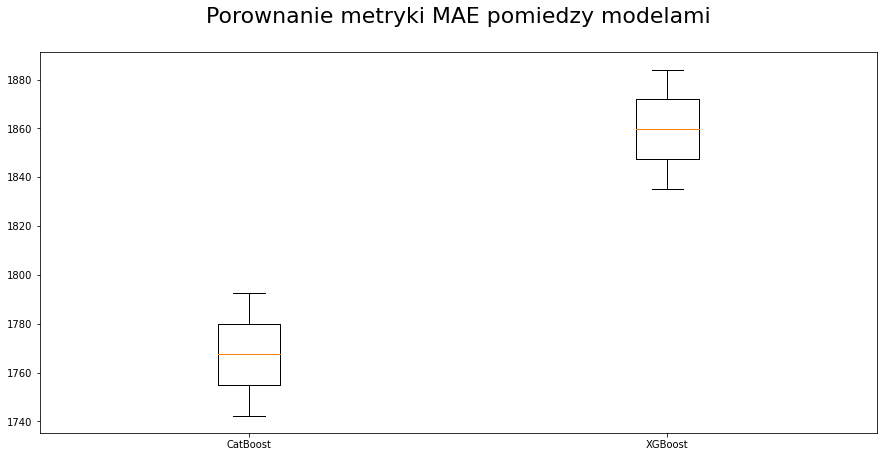

In [44]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)

plt.title('Porownanie metryki MAE pomiedzy modelami\n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

# Hyperopt

In [45]:
def run_model(model,feats):
    X = df_train_final[feats]
    y = df_train_final['weekly_sales']
    
    scores = []
    mse_results = []
    mae_results = []
    
    for train_idx, test_idx in tscv.split(X,y):
        #scaler = MinMaxScaler()

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        print(X_train.shape,"-----", X_test.shape)

#         X_train_normalized = scaler.fit_transform(X_train)
#         X_test_normalized = scaler.transform(X_test)
        X_train_normalized = X_train.copy()
        X_test_normalized = X_test.copy()

        model.fit(X_train_normalized, y_train)
        y_pred_log = model.predict(X_test_normalized)
        y_pred = np.exp(y_pred_log)

        y_test = np.exp(y_test) 
        mae = mean_absolute_error(y_test, y_pred)

        mae_results.append(mae)

    scores.append(mae_results)
    
    return np.mean(scores), np.std(scores)

In [49]:
def obj_func(params):
    print(params)
    
    mean_mae, score_std = run_model(XGBRegressor(**params),feats)
    print(mean_mae, score_std)
    return{'loss': np.abs(mean_mae), 'status': STATUS_OK}

xgb_reg_params = {
'learning_rate':     hp.choice('learning_rate',          np.arange(0.05,0.1,0.01)),
'max_depth':         hp.choice("max_depth",              np.arange(10,16,1,dtype = int)),
# 'subsample':         hp.quniform('subsample', 0.7, 1, 0.05),
# 'colsample_bytree' : hp.quniform('colsample_bytree', 0.5,1,0.05),
'objective' : 'reg:squarederror',
'n_estimators': 500,
'seed': 0
    }
best = fmin(obj_func,xgb_reg_params,algo = tpe.suggest,max_evals = 10)

{'learning_rate': 0.08000000000000002, 'max_depth': 10, 'n_estimators': 500, 'objective': 'reg:squarederror', 'seed': 0}
(94735, 34)                                           
-----                                                 
(94733, 34)                                           
(189468, 34)                                          
-----                                                 
(94733, 34)                                           
1327.3003787119837                                    
26.78963818457339                                     
{'learning_rate': 0.07, 'max_depth': 10, 'n_estimators': 500, 'objective': 'reg:squarederror', 'seed': 0}
(94735, 34)                                                                        
-----                                                                              
(94733, 34)                                                                        
(189468, 34)                                                                     

In [50]:
space_eval(xgb_reg_params,best)

{'learning_rate': 0.08000000000000002,
 'max_depth': 14,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'seed': 0}

## Przewidywanie na niewidzianych wcześniej danych

In [51]:
X_train = df_train_final[feats]
y_train = df_train_final['weekly_sales']
X_test = df_test_final[feats]

In [52]:
def fit_predict(model):
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)
    pred = np.exp(y_pred_log)
    return pred

In [53]:
pred = fit_predict(XGBRegressor(max_depth=14, n_estimators=500, learning_rate=0.08000000000000002, seed=0))

In [54]:
df_sales_test["weekly_sales"] = pred
df_sales_test[ ["id", "weekly_sales"] ].to_csv("../output/XGBoostOptimized.csv", index=False)
df_sales_test[ ["id", "weekly_sales"] ]

,id,weekly_sales
0,0,415.854675
2,2,75658.203125
5,5,17622.835938
6,6,43057.757812
8,8,44074.886719
...,...,...
421557,421557,12000.126953
421560,421560,1.124349
421564,421564,10501.811523
421568,421568,64.156326
